The following notebook will create a model to predict ( or classify ) whether a given swiss product review is helpful or not.

The links towards the papers that inspired this work should be available here: ["Predicting Amazon review helpfulness"](https://cseweb.ucsd.edu/~jmcauley/cse255/reports/wi15/Shitij_Bhargava.pdf) and ["Predicting Helpfulness Ratings of Amazon Product Reviews"](http://cs229.stanford.edu/proj2014/Jordan%20Rodak,%20Minna%20Xiao,%20Steven%20Longoria,%20Predicting%20Helpfulness%20Ratings%20of%20Amazon%20Product%20Reviews.pdf)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

Open the file containing the filtered helpful swiss reviews. This notebook uses the smaller such dataset, in which the swiss reviews had at least 10 helpful flags (votes) and totalling to 10729 reviews.

In [2]:
with open("data/swiss-reviews-helpful-correct.txt", 'r') as fp:
    s_swiss_rev_help = fp.readlines()

In [3]:
len(s_swiss_rev_help)

10729

In [4]:
s_swiss_rev_help[0]

'{"reviewerID": "A08719731S0E5PHVCG6EZ", "asin": "B005WFPLWA", "reviewerName": "Sophie Clouet", "helpful": [0, 10], "reviewText": "JE NE VOIS PAS ENCORE D\'AM&Eacute;LIORATION CONTRE LA PERTE DES CHEVEUX.  JE VERRAI APR&Egrave;S LE TRAITEMENT SI C\'EST BON OU NON", "overall": 1.0, "summary": "COMMENTAIRE", "unixReviewTime": 1356739200, "reviewTime": "12 29, 2012"}\n'

The ARI score is a measure of the readability of a piece of text and it represents one of the features in the later model.

In [5]:
import re
import nltk.data
from nltk import wordpunct_tokenize

# split into words by punctuations
# remove punctuations and all '-' words
RE = re.compile('[0-9a-z-]', re.I)
s_sent = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
def get_ARI_score(text):
    words = list(filter(lambda w: RE.search(w) and w.replace('-', ''), wordpunct_tokenize(text)))
    wordc = len(words)
    charc = sum(len(w) for w in words)
    sents = s_sent.tokenize(text)
    sentc = len(sents)
    return 4.71 * charc / (wordc + 0.1) + 0.5 * (wordc + 0.1) / (sentc + 0.1) - 21.43

In the next step we convert the file containing the reviews into a pandas dataframe as it is easier to work with it in that format.

In [7]:
def convert_to_dict(line):
    l = line.rstrip('\n')
    l = eval(l)
    return l

In [8]:
s_dict_list = []
counter = 1
for item in s_swiss_rev_help:
    if(counter%500 == 0):
        print(counter)
    counter += 1
    s_dict_list.append(convert_to_dict(item))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500


In [9]:
s_features = pd.DataFrame(s_dict_list)

We remove the 'reviewTime', 'reviewerName', 'unixReviewTime' columns from the dataframe as they will not be used as features nor used to construct other features. As a note, in the papers which inspired the current work these columns were used to obtain features such as the age of a review and the time delay of the review.

In [10]:
s_features.drop(['reviewTime', 'reviewerName', 'unixReviewTime'],inplace=True,axis=1)

In [242]:
s_features.head(3)

,asin,helpful,overall,reviewText,reviewerID,summary,rev_length,all_caps,sent_count,que_exc_ratio,ari_score,dev_mean_score,Y
0,B005WFPLWA,"[0, 10]",-1.418073,JE NE VOIS PAS ENCORE D'AM&Eacute;LIORATION CO...,A08719731S0E5PHVCG6EZ,COMMENTAIRE,-0.759382,13.618261,-0.777128,-0.323302,-0.690390,-0.746869,0
1,B00064FXH0,"[17, 20]",-1.418073,I ordered this thinking it would speed up my r...,A1006UA0557GXP,Great idea...next year when the bugs are worke...,0.408628,-0.024824,0.938594,0.184259,-0.229376,-0.785152,1
2,B003VAHYTG,"[162, 174]",0.985577,I mainly got this set for music and some games...,A100JEV1I8ZHJ8,Quality 2.1 System for Music and Games,-0.422216,-0.046337,-0.575278,-0.323302,0.425492,0.780581,1


### Feature gathering

Feature 1: Review length measured by the number of characters of the text.
It will be noted here that after the creation of each feature it will also be standardized.

In [12]:
# Review length
s_features["rev_length"] = s_features['reviewText'].apply(lambda x: len(x))
s_features["rev_length"] = (s_features["rev_length"] - \
                          s_features["rev_length"].mean()) / s_features["rev_length"].std()

Feature 2: The ratio of the number of caps to the total number of characters. +1 was added in the denominator to prevent division by 0 (apparently there are zero-length reviews).

In [13]:
# Number of all caps
def count_all_caps(text):
    count = 0
    for i in text:
        if(i.isupper()):
            count += 1
    return count/(len(text) + 1)

In [14]:
s_features["all_caps"] = s_features['reviewText'].apply(count_all_caps)
s_features["all_caps"] = (s_features["all_caps"] - \
                          s_features["all_caps"].mean()) / s_features["all_caps"].std()

Feature 3: Total number of sentences

In [15]:
# Sentence count
s_features["sent_count"] = s_features['reviewText'].apply(lambda x: \
                                                      len(nltk.tokenize.sent_tokenize(x)))

In [16]:
s_features["sent_count"] = (s_features["sent_count"] - \
                          s_features["sent_count"].mean()) / s_features["sent_count"].std()

Feature 4: Question and exclamation marks ratio to the length of the text

In [17]:
# Question and exclamation marks ratio to characters
def count_ques_exc_ratio(text):
    count = 0
    for i in text:
        if(i == '!' or i == '?'):
            count += 1
    return count*1.0/(len(text)+1)

In [18]:
s_features["que_exc_ratio"] = s_features['reviewText'].apply(count_ques_exc_ratio)
s_features["que_exc_ratio"] = (s_features["que_exc_ratio"] - \
                          s_features["que_exc_ratio"].mean()) / s_features["que_exc_ratio"].std()

Feature 5: ARI readability score

In [19]:
# ARI readability index
s_features["ari_score"] = s_features['reviewText'].apply(get_ARI_score)

In [20]:
s_features["ari_score"] = (s_features["ari_score"] - \
                          s_features["ari_score"].mean()) / s_features["ari_score"].std()

Feature 6: The deviation of the review's rating from the mean rating score of the respective product

In [21]:
# load mean rating scores for considered asins
with open("data/asin_ratings_small.json", "r") as fp:
    s_asin_rev_ratings = fp.readlines()

In [22]:
s_dict_list_ar = []
for item in s_asin_rev_ratings:
    s_dict_list_ar.append(convert_to_dict(item))

In [23]:
s_dict_ar = dict([(key,d[key]) for d in s_dict_list_ar for key in d])

In [24]:
def get_dev_mean_score(row):
    if(row['asin'] in s_dict_ar.keys()):
        return row['overall'] - s_dict_ar[row['asin']]
    print("Should not get here")
    return 0

In [25]:
s_features['dev_mean_score'] = s_features.apply(get_dev_mean_score, axis=1)

In [26]:
# should only be standardized after dev_mean_score has been computed
s_features["overall"] = (s_features["overall"] - \
                          s_features["overall"].mean()) / s_features["overall"].std()

In [27]:
s_features["dev_mean_score"] = (s_features["dev_mean_score"] - \
                          s_features["dev_mean_score"].mean()) / s_features["dev_mean_score"].std()

In [29]:
len(s_features)

10729

In the next step we remove duplicate ('asin', 'reviewText') pair values. There other approaches as well as removing duplicates only by the 'reviewText' field, but this would reduce the dataset considerably. Here we can make an interesting observation, regarding the fact that a lot of the reviews are copied in different products, without changing the content at the very least. 

In [30]:
s_features.drop_duplicates(subset=['asin','reviewText'], keep='first', inplace=True)

In [31]:
len(s_features)

10693

In the next part we create the labels by considering a review 'helpful' only if it has at least 0.6 helpful ratio (helpful votes / total votes). This approach was also used in the mentioned papers, the motivation being that the normal/intuitive threshold of 0.5 would be a little ambiguous and as such a more strict threshold was used.

In [32]:
def create_labels(pair):
    if(pair[0]*1.0/pair[1] >= 0.6):
        return 1
    else:
        return 0

In [33]:
s_features['Y'] = s_features['helpful'].apply(create_labels)

To complete the set of features considered for the learning model we use tf-idf on the corpus of helpful reviews. In a little more detail we first compute the dictionary of the corpus and then attach to each word its tf-idf score. A given review will contain as features the vocabulary of words together with the tf-idf scores for its respective words contained in the review.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
s_count_vect = CountVectorizer(stop_words='english')
s_X_train_counts = s_count_vect.fit_transform(list(s_features['reviewText']))

In [35]:
s_X_train_counts.shape

(10693, 36391)

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
s_tf_transformer = TfidfTransformer().fit(s_X_train_counts)
s_X_train_tf = s_tf_transformer.transform(s_X_train_counts)

In [37]:
s_X_train_tf.shape

(10693, 36391)

In order to preserve the sparsity we scale by the maximum absolute value.

In [38]:
from sklearn.preprocessing import scale, maxabs_scale

In [39]:
maxabs_scale(s_X_train_tf, copy=False)

<10693x36391 sparse matrix of type '<class 'numpy.float64'>'
	with 737288 stored elements in Compressed Sparse Row format>

In [40]:
s_Y = s_features.as_matrix(['Y'])

In [41]:
s_Y.shape

(10693, 1)

In [42]:
s_X_train_else = s_features.as_matrix(['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score'])

In [43]:
type(s_X_train_else)

numpy.ndarray

We combine the features constructed until now into the final feature matrix s_X

In [44]:
from scipy.sparse import hstack
s_X = hstack([s_X_train_tf, s_X_train_else])

In [45]:
type(s_X)

scipy.sparse.coo.coo_matrix

In [46]:
s_X.shape

(10693, 36398)

In [47]:
s_Y.shape

(10693, 1)

In [48]:
s_Y = s_Y.reshape((s_Y.shape[0],))

In [49]:
s_Y.shape

(10693,)

### Time for some machine learning

Load the classifier models to be tested: Random forest, Logistic regression, AdaBoost, SVC (from SVM)

In [134]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

Split the dataset into training and testing and see how the classifiers roughly behave

In [53]:
x_tr, x_te, y_tr, y_te = train_test_split(s_X, s_Y, train_size=0.8)

In [54]:
s_cllr = LogisticRegression(class_weight='balanced', n_jobs=-1, C=1e2)

In [55]:
s_cllr.fit(x_tr, y_tr)
print("Test set accuracy:" , s_cllr.score(x_te, y_te))
print("Train set accuracy:", s_cllr.score(x_tr, y_tr))

Test set accuracy: 0.850864890136
Train set accuracy: 0.999181669394


In [56]:
s_clrf = RandomForestClassifier(n_estimators = 10, class_weight='balanced', n_jobs=-1)

In [57]:
s_clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clrf.score(x_te, y_te))
print("Train set accuracy:", s_clrf.score(x_tr, y_tr))

Test set accuracy: 0.854604955587
Train set accuracy: 0.9957914426


In [58]:
s_clab = AdaBoostClassifier()

In [59]:
s_clab.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clab.score(x_te, y_te))
print("Train set accuracy:", s_clab.score(x_tr, y_tr))

Test set accuracy: 0.826554464703
Train set accuracy: 0.856675239654


In [60]:
# C could be tuned for regularization, by default it is C=1.0
s_clsvc = SVC(class_weight='balanced', kernel='linear', probability=True)

In [61]:
s_clsvc.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clsvc.score(x_te, y_te))
print("Train set accuracy:", s_clsvc.score(x_tr, y_tr))

Test set accuracy: 0.84899485741
Train set accuracy: 0.99894786065


In [62]:
sum(y_tr)/len(y_tr)

0.78127191956979192

The accuracy does not bring any meaningful observations as the 2 classes are highly imbalanced. The ratio of the positive (helpful) samples to the negative (unhelpful) samples is approximately 3:1.

One alternative is to compute the F1 score for each classfier using cross-validation

In [69]:
shuffle = KFold(n_splits=10, shuffle=True)

In [70]:
f1s_rf = cross_val_score(s_clrf, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [74]:
print("F1 score mean -- Random forest:" , f1s_rf.mean())
print("F1 score std -- Random forest:", f1s_rf.std())

F1 score mean -- Random Forest: 0.908334920568
F1 score std -- Random Forest: 0.0075697501992


In [75]:
f1s_lr = cross_val_score(s_cllr, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [76]:
print("F1 score mean -- Logistic regression:" , f1s_lr.mean())
print("F1 score std -- Logistic regression:", f1s_lr.std())

F1 score mean -- Logistic regression: 0.908059903298
F1 score std -- Logistic regression: 0.00587383646152


In [77]:
f1s_ab = cross_val_score(s_clab, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [78]:
print("F1 score mean -- AdaBoost:" , f1s_ab.mean())
print("F1 score std -- AdaBoost:", f1s_ab.std())

F1 score mean -- AdaBoost: 0.90128576689
F1 score std -- AdaBoost: 0.00710639811693


In [79]:
f1s_svc = cross_val_score(s_clsvc, s_X, s_Y, cv=shuffle, scoring='f1', n_jobs=-1)

In [80]:
print("F1 score mean -- SVC:" , f1s_svc.mean())
print("F1 score std -- SVC:", f1s_svc.std())

F1 score mean -- SVC: 0.907999089142
F1 score std -- SVC: 0.00838618327585


The F1 score is quite similar for all the classifiers, with the random forest model edging the logistic regression and svc models.

Next we can also take a look at the confusion matrix for each model.

In [94]:
s_y_pred_rf = cross_val_predict(s_clrf, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [97]:
s_y_pred_lr = cross_val_predict(s_cllr, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [98]:
s_y_pred_ab = cross_val_predict(s_clab, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [99]:
s_y_pred_svc = cross_val_predict(s_clsvc, s_X, s_Y, cv=shuffle, n_jobs=-1)

In [100]:
s_cm_rf = confusion_matrix(s_Y, s_y_pred_rf)

In [101]:
s_cm_lr = confusion_matrix(s_Y, s_y_pred_lr)

In [102]:
s_cm_ab = confusion_matrix(s_Y, s_y_pred_ab)

In [103]:
s_cm_svc = confusion_matrix(s_Y, s_y_pred_svc)

In [111]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1369 1000]
 [ 615 7709]]


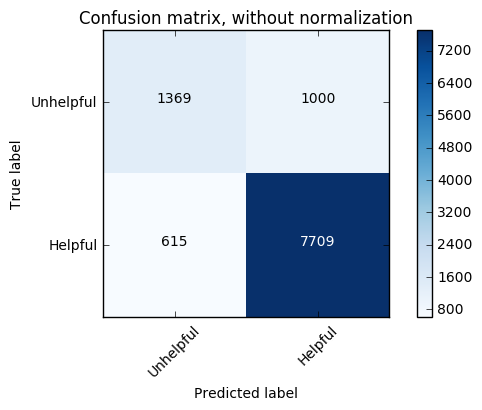

In [112]:
# Plot non-normalized confusion matrix -- Random forest
plt.figure()
plot_confusion_matrix(s_cm_rf, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[1550  819]
 [ 748 7576]]


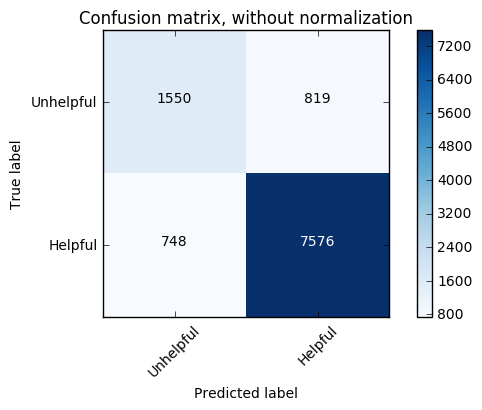

In [106]:
# Plot non-normalized confusion matrix -- Logistic regression
plt.figure()
plot_confusion_matrix(s_cm_lr, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[1308 1061]
 [ 665 7659]]


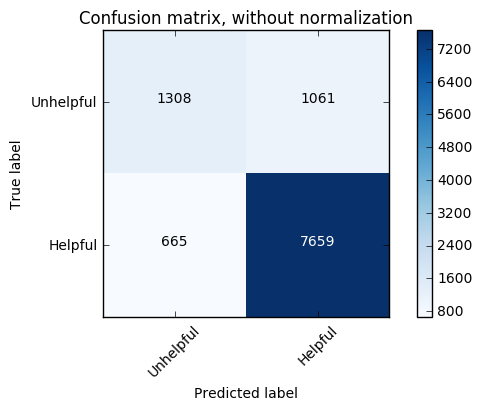

In [107]:
# Plot non-normalized confusion matrix -- AdaBoost
plt.figure()
plot_confusion_matrix(s_cm_ab, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[1526  843]
 [ 725 7599]]


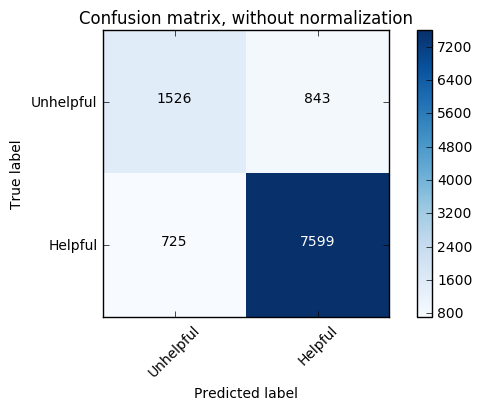

In [108]:
# Plot non-normalized confusion matrix -- SVC
plt.figure()
plot_confusion_matrix(s_cm_svc, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

After preforming cross-validation to find the predictions of each model, we plotted the confusion matrix with respect to each model's predictions. 

There are different measurements based on the confusion matrix, the F1 score (harmonic mean between precision and recall) computed before being one of them. One measurement which could be more useful is the false positive rate (FP / N; FP = false positives, N = total negatives). The intuition behind this is the following: classifying true helpful reviews as unhelpful is less significant than classifying true unhelpful reviews as helpful. We see that all the models perform well in identifying helpful reviews, yet some are better at handling the unhelpful reviews. The false positive rate focuses on finding which model is better or more sensitive for handling negative samples (unhelpful reviews).

In [118]:
tn_rf, fp_rf, fn_rf, tp_rf = s_cm_rf.ravel()

In [119]:
false_positive_rate_rf = fp_rf / (fp_rf + tn_rf)
false_positive_rate_rf

0.42211903756859437

In [113]:
tn_lr, fp_lr, fn_lr, tp_lr = s_cm_lr.ravel()

In [116]:
false_positive_rate_lr = fp_lr / (fp_lr + tn_lr)
false_positive_rate_lr

0.34571549176867877

In [120]:
tn_ab, fp_ab, fn_ab, tp_ab = s_cm_ab.ravel()

In [121]:
false_positive_rate_ab = fp_ab / (fp_ab + tn_ab)
false_positive_rate_ab

0.44786829886027862

In [122]:
tn_svc, fp_svc, fn_svc, tp_svc = s_cm_svc.ravel()

In [123]:
false_positive_rate_svc = fp_svc / (fp_svc + tn_svc)
false_positive_rate_svc

0.35584634867032505

Logistic regression provides the smallest false positive rate, suggesting that it is the better model for handling the negative cases

Next measurement step will be to analyze the roc curves for each model.

In [196]:
# with StratifiedKFold the folds are made by preserving the percentage of samples for each class
shuffle_5 = StratifiedKFold(n_splits=5, shuffle=True)

In [197]:
from itertools import cycle
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue'])

In [204]:
from scipy import interp
def plot_roc_cv(classifier):
    i = 0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for (train, test), color in zip(shuffle_5.split(s_X, s_Y), colors):
        classifier.fit(s_X.tocsr()[train], s_Y[train])
        probas_ = classifier.predict_proba(s_X.tocsr()[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(s_Y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
        i += 1
        
    mean_tpr /= shuffle_5.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--', label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

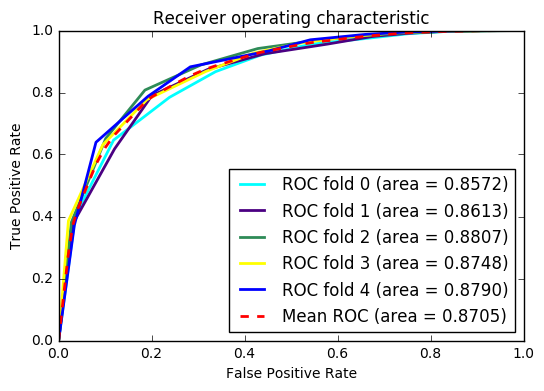

In [206]:
# ROC curve(s) for Random Forest
plt.figure()
plot_roc_cv(s_clrf)
plt.show()

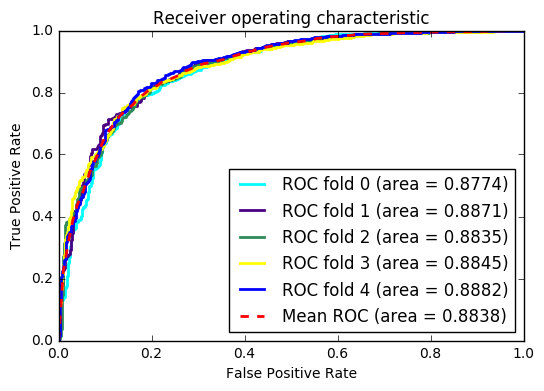

In [207]:
# ROC curve(s) for Logistic Regression
plt.figure()
plot_roc_cv(s_cllr)
plt.show()

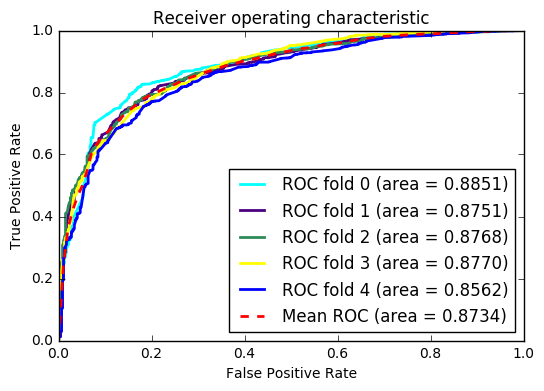

In [208]:
# ROC curve(s) for AdaBoost
plt.figure()
plot_roc_cv(s_clab)
plt.show()

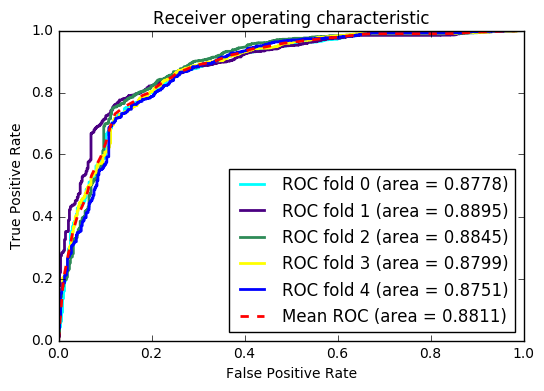

In [209]:
# ROC curve(s) for SVC
plt.figure()
plot_roc_cv(s_clsvc)
plt.show()

Based on the above results, logistic regression provides the best mean roc area under curve, followed closely by the svc classifier.

After observing the results of the F1 score, FPR (false positive rate) and the area under the ROC curve (AUC) logistic regression is the more robust model out of the trained classifiers.

### Most relevant features

In the last part of the analysis we try to get an intuition of the most relevant features when training the random forest. For the other classifiers identifying the most important features it is not as straight forward as for a random forest.

s_feature_names stores the name of the features (the vocabulary together with the constructed features)

In [237]:
s_words_list = s_count_vect.get_feature_names()
s_other_feats = ['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score']
s_feature_names = s_words_list + s_other_feats

In [238]:
len(s_feature_names) == s_X.shape[1]

True

In [239]:
# the number of the most relevant features to be plotted
number_of_features = 15
importances = s_clrf.feature_importances_
# sort the indices based on the importance values
indices = np.argsort(importances)[::-1]

# the names of the features based on the indices and how many to select
temp_names = []
for i in range(number_of_features):
    temp_names.append(s_feature_names[indices[i]])

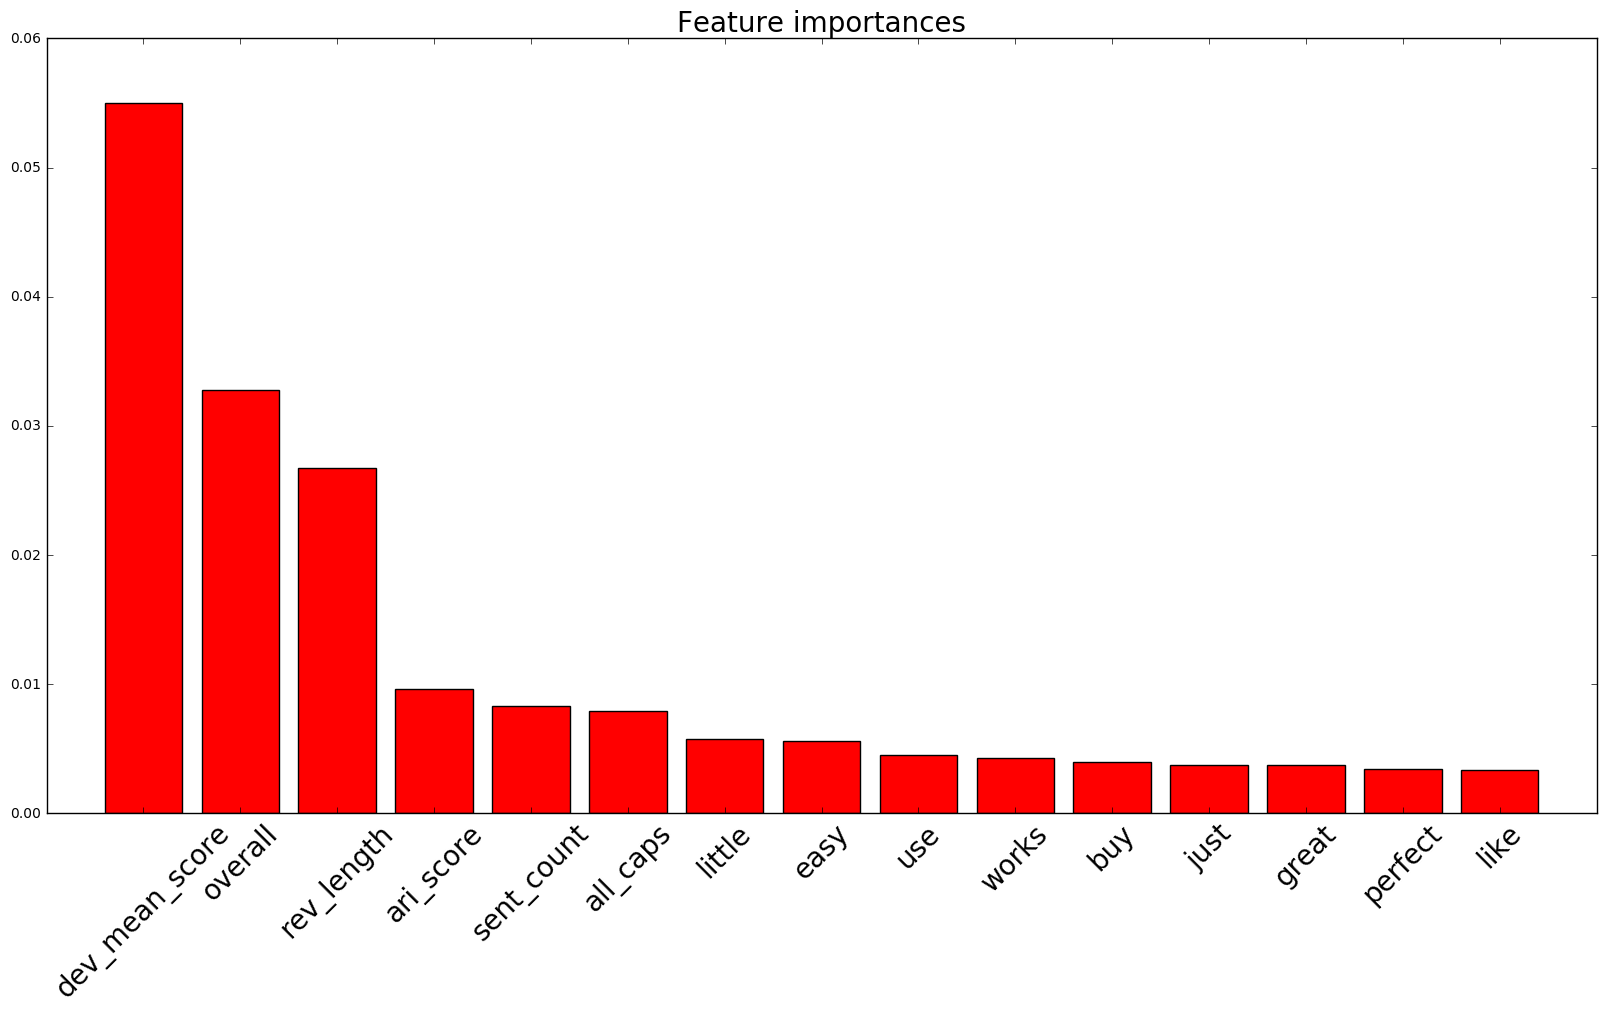

Feature ranking:
1. feature dev_mean_score (0.054988)
2. feature overall (0.032803)
3. feature rev_length (0.026713)
4. feature ari_score (0.009627)
5. feature sent_count (0.008342)
6. feature all_caps (0.007921)
7. feature little (0.005769)
8. feature easy (0.005595)
9. feature use (0.004540)
10. feature works (0.004311)
11. feature buy (0.004005)
12. feature just (0.003755)
13. feature great (0.003749)
14. feature perfect (0.003410)
15. feature like (0.003393)


In [240]:
# Plot the feature importances of the random forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize=20)
plt.bar(range(number_of_features), importances[indices[:number_of_features]],
       color="r", align="center")#, yerr=std[indices])
plt.xticks(range(number_of_features), temp_names, fontsize=20, rotation=45)
plt.xlim([-1, number_of_features])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(number_of_features):
    print("%d. feature %s (%f)" % (f + 1,  s_feature_names[indices[f]], importances[indices[f]]))
